In [ ]:
Figure 6 is a sensitivity analysis across various model parameter variations

# TODO: remove any non-unique parameters, and include the noise parameter (this noise parameter seems to be the issue)

In [1]:
include(joinpath("..","src","setup.jl"))

┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/AuditoryBistabilityLE/RqG8S.ji for AuditoryBistabilityLE [7e25a372-ade5-11e8-17af-a30e5a9e2c28]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/Feather/RgcL0.ji for Feather [becb17da-46f6-5d3c-ad1b-1c5fe96bc73c]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/Gadfly/DvECm.ji for Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1190
┌ Info: Loading Cairo backend into Compose.jl
└ @ Compose /Users/davidlittle/.julia/packages/Compose/BYWXX/src/Compose.jl:161
┌ Warning: Package Compose does not have Cairo in its dependencies:
│ - If you have Compose checked out for development and have
│   added Cairo as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Compose
│ Loading Cairo into Compose fr

RObject{VecSxp}
$rcalljl_options
$rcalljl_options$height
[1] 360

$rcalljl_options$width
[1] 432




In [2]:
datadir = joinpath("..","data","count_lengths","run_2018-12-06")

"../data/count_lengths/run_2018-12-06"

In [3]:
noise_datadir = joinpath(datadir,"..","run_2018-12-14")

"../data/count_lengths/run_2018-12-06/../run_2018-12-14"

In [4]:
fields = [:f_c_a,:f_c_m,:f_c_σ,:s_c_a,:s_c_m,:s_c_σ,:t_c_a,:t_c_m,:t_c_σ,
          :f_τ_a,:f_τ_m,:s_τ_a,:s_τ_m,:t_τ_a,:t_τ_m];

In [5]:
params = load_params(joinpath(datadir,"params.jld2"))
params[:pindex] = 1:size(params,1)
settings = joinpath("..","src","settings.toml")

results = []
for_results_in(joinpath(datadir,"data")) do entry
  push!(results,DataFrame(length=entry["lengths"],
                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                          created=entry["created"],
                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df = vcat(results...);
head(df)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


,length,percepts,created,pindex
,Float64,Int64,DateTime,Int64
1,0.3,1,2018-12-06T23:52:05.717,1
2,0.9,2,2018-12-06T23:52:05.717,1
3,4.4,1,2018-12-06T23:52:05.717,1
4,0.6,2,2018-12-06T23:52:05.717,1
5,3.0,1,2018-12-06T23:52:05.717,1
6,0.3,2,2018-12-06T23:52:05.717,1


In [6]:
# turns out there are some non-unique parameter values with this; remove those (in the future do it before running the simulation)
paramssel = unique!(params,[fields;:Δf])
size(paramssel,1)

1575

In [7]:
size(df)

(448632, 4)

In [8]:
dfsel = @where(df,in.(:pindex,Ref(paramssel.pindex)));
size(dfsel)

(348782, 4)

In [9]:
paramssel[:old_pindex] = paramssel.pindex;
dfsel[:old_pindex] = dfsel.pindex;

In [10]:
paramssel[:pindex] = 1:size(paramssel,1)
for row in 1:size(dfsel,1)
    i = findfirst(isequal(dfsel.old_pindex[row]),paramssel.old_pindex)
    if i isa Nothing
        error("Can't find old_pindex $(dfsel.old_pindex[row])")
    end
    dfsel.pindex[row] = paramssel.pindex[i]
end
head(dfsel)

,length,percepts,created,pindex,old_pindex
,Float64,Int64,DateTime,Int64,Int64
1,0.3,1,2018-12-06T23:52:05.717,1,1
2,0.9,2,2018-12-06T23:52:05.717,1,1
3,4.4,1,2018-12-06T23:52:05.717,1,1
4,0.6,2,2018-12-06T23:52:05.717,1,1
5,3.0,1,2018-12-06T23:52:05.717,1,1
6,0.3,2,2018-12-06T23:52:05.717,1,1


In [11]:
delete!(dfsel,:old_pindex);
delete!(paramssel,:old_pindex);

In [12]:
print(maximum(paramssel.pindex))
size(paramssel)

1575

(1575, 36)

we've gotten rid of the redundant parameters, now load the missing noise variations

In [13]:
params = load_params(joinpath(noise_datadir,"params.jld2"))
params[:pindex] = 1:size(params,1)

results = []
for_results_in(joinpath(noise_datadir,"data")) do entry
  push!(results,DataFrame(length=entry["lengths"],
                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                          created=entry["created"],
                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df = vcat(results...);
head(df)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


,length,percepts,created,pindex
,Float64,Int64,DateTime,Int64
1,5.6,1,2018-12-17T14:16:27.018,1
2,0.6,2,2018-12-17T14:16:27.018,1
3,3.0,1,2018-12-17T14:16:27.018,1
4,0.3,2,2018-12-17T14:16:27.018,1
5,0.9,1,2018-12-17T14:16:27.018,1
6,0.9,2,2018-12-17T14:16:27.018,1


In [14]:
maximum(params.pindex)

675

In [15]:
size(params)

(675, 36)

In [16]:
df.pindex .+= maximum(dfsel.pindex);
params.pindex .+= maximum(paramssel.pindex);

In [17]:
df = vcat(dfsel,df);
params = vcat(paramssel,params)

,f_W_m_σ,f_c_m,t_c_a,t_c_m,f,t_W_m_c,t_c_x,f_c_x,t_W_m_σ_t,s_τ_σ,f_c_a,f_c_σ,s_c_m,f_τ_a,s_c_σ,Δt,s_τ_m,s_c_x,t_W_m_σ_ϕ,t_τ_a,s_c_a,t_τ_m,t_c_σ,t_τ_x,s_W_m_c,s_τ_a,f_W_m_c,t_τ_σ,f_τ_σ,f_τ_x,Δf,t_W_m_σ_N,f_τ_m,s_τ_x,s_W_m_σ,pindex
,Float64,Float64,Float64,Float64,Quantity…,Float64,Float64,Float64,Float64,Quantity…,Float64,Float64,Float64,Quantity…,Float64,Quantity…,Quantity…,Float64,Float64,Quantity…,Float64,Quantity…,Float64,Quantity…,Float64,Quantity…,Float64,Quantity…,Quantity…,Quantity…,Int64,Float64,Quantity…,Quantity…,Float64,Int64
1,5.6,0.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,0.0,0.2,0.0,1.0 s,0.0,120 ms,0.35 s,3.0,7.0,3.0 s,0.0,0.35 s,0.0,500 ms,6.0,3.0 s,6.0,500 ms,500 ms,500 ms,3,3.0,0.35 s,500 ms,15.0,1
2,5.6,5.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,0.0,0.2,0.0,1.0 s,0.0,120 ms,0.35 s,3.0,7.0,3.0 s,0.0,0.35 s,0.0,500 ms,6.0,3.0 s,6.0,500 ms,500 ms,500 ms,3,3.0,0.35 s,500 ms,15.0,2
3,5.6,63.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,0.0,0.2,0.0,1.0 s,0.0,120 ms,0.35 s,3.0,7.0,3.0 s,0.0,0.35 s,0.0,500 ms,6.0,3.0 s,6.0,500 ms,500 ms,500 ms,3,3.0,0.35 s,500 ms,15.0,3
4,5.6,790.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,0.0,0.2,0.0,1.0 s,0.0,120 ms,0.35 s,3.0,7.0,3.0 s,0.0,0.35 s,0.0,500 ms,6.0,3.0 s,6.0,500 ms,500 ms,500 ms,3,3.0,0.35 s,500 ms,15.0,4
5,5.6,10000.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,0.0,0.2,0.0,1.0 s,0.0,120 ms,0.35 s,3.0,7.0,3.0 s,0.0,0.35 s,0.0,500 ms,6.0,3.0 s,6.0,500 ms,500 ms,500 ms,3,3.0,0.35 s,500 ms,15.0,5
6,5.6,0.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,5.0,0.2,0.0,1.0 s,0.0,120 ms,0.35 s,3.0,7.0,3.0 s,0.0,0.35 s,0.0,500 ms,6.0,3.0 s,6.0,500 ms,500 ms,500 ms,3,3.0,0.35 s,500 ms,15.0,6
7,5.6,5.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,5.0,0.2,0.0,1.0 s,0.0,120 ms,0.35 s,3.0,7.0,3.0 s,0.0,0.35 s,0.0,500 ms,6.0,3.0 s,6.0,500 ms,500 ms,500 ms,3,3.0,0.35 s,500 ms,15.0,7
8,5.6,63.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,5.0,0.2,0.0,1.0 s,0.0,120 ms,0.35 s,3.0,7.0,3.0 s,0.0,0.35 s,0.0,500 ms,6.0,3.0 s,6.0,500 ms,500 ms,500 ms,3,3.0,0.35 s,500 ms,15.0,8
9,5.6,790.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,5.0,0.2,0.0,1.0 s,0.0,120 ms,0.35 s,3.0,7.0,3.0 s,0.0,0.35 s,0.0,500 ms,6.0,3.0 s,6.0,500 ms,500 ms,500 ms,3,3.0,0.35 s,500 ms,15.0,9


In [26]:
size(params)

(2250, 36)

In [18]:
progress = Progress(length(groupby(params,fields)))
herr = human_error(resample=10_000,N=N_for_pressnitzer_hupe_2006)
df_summary = by(params,fields) do row
    next!(progress)
    err = model_error(df,params;(k => row[1,k] for k in fields)...)
    DataFrame(stream_error = err.stream,length_error = err.lengths,eratio = error_ratio(err,herr))
end
head(df_summary)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


,f_c_a,f_c_m,f_c_σ,s_c_a,s_c_m,s_c_σ,t_c_a,t_c_m,t_c_σ,f_τ_a,f_τ_m,s_τ_a,s_τ_m,t_τ_a,t_τ_m,stream_error,length_error,eratio
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Float64,Float64,Float64
1,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.0 s,0.35 s,3.0 s,0.35 s,3.0 s,0.35 s,0.245575,0.448907,2.02282
2,0.0,5.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.0 s,0.35 s,3.0 s,0.35 s,3.0 s,0.35 s,0.262555,0.660822,2.58233
3,0.0,63.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.0 s,0.35 s,3.0 s,0.35 s,3.0 s,0.35 s,0.274547,1.0,3.41716
4,0.0,790.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.0 s,0.35 s,3.0 s,0.35 s,3.0 s,0.35 s,0.275776,1.0,3.42207
5,0.0,10000.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.0 s,0.35 s,3.0 s,0.35 s,3.0 s,0.35 s,0.275648,1.0,3.42156
6,5.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.0 s,0.35 s,3.0 s,0.35 s,3.0 s,0.35 s,0.246174,0.229317,1.51575


In [19]:
dfplot = @linq df_summary |>
    rename_levels_for([:stream_error,:length_error,:eratio],suffixes=[:c_a,:c_m,:τ_a,:τ_m,:c_σ]) |>
    transform(a = packaxes(:c_a), m = packaxes(:c_m), rand = randn(length(:c_a))) |>
    transform(eratio_str = fmt.("01.2f",:eratio))
              
head(dfplot)

,c_a,c_m,τ_a,τ_m,c_σ,level,stream_error,length_error,eratio,a,m,rand,eratio_str
,Float64,Float64,Quantity…,Quantity…,Float64,String,Float64,Float64,Float64,Float64,Float64,Float64,String
1,0.0,0.0,1.0 s,0.35 s,0.2,Peripheral,0.245575,0.448907,2.02282,0.0,0.0,0.17655,2.02
2,0.0,5.0,1.0 s,0.35 s,0.2,Peripheral,0.262555,0.660822,2.58233,0.0,1.5,0.246941,2.58
3,0.0,63.0,1.0 s,0.35 s,0.2,Peripheral,0.274547,1.0,3.41716,0.0,2.5,-2.02365,3.42
4,0.0,790.0,1.0 s,0.35 s,0.2,Peripheral,0.275776,1.0,3.42207,0.0,3.5,-0.63888,3.42
5,0.0,10000.0,1.0 s,0.35 s,0.2,Peripheral,0.275648,1.0,3.42156,0.0,5.0,-0.360646,3.42
6,5.0,0.0,1.0 s,0.35 s,0.2,Peripheral,0.246174,0.229317,1.51575,1.5,0.0,0.756022,1.52


In [20]:
dfplot[:variation] = "unknown"
dfplot[:varvalue] = NaN
sel = findall(!isequal(3.0s),dfplot.τ_a)
dfplot[sel,:variation] = "τ_a"
dfplot[sel,:varvalue] = ustrip.(uconvert.(s,dfplot[sel,:τ_a]))

sel = findall(!isequal(350ms),dfplot.τ_m)
dfplot[sel,:variation] = "τ_m"
dfplot[sel,:varvalue] = ustrip.(uconvert.(s,dfplot[sel,:τ_m]))

sel = findall(!isequal(0.2),dfplot.c_σ)
dfplot[sel,:variation] = "c_σ"
dfplot[sel,:varvalue] = dfplot[sel,:c_σ];

sel = findall((dfplot.c_σ .== 0.2) .& (dfplot.τ_a .== 3.0s) .& (dfplot.τ_m .== 350ms));
dfplot[sel,:variation] = "original"
dfplot[sel,:varvalue] = 0.0

0.0

In [21]:
dfsumplot = by(dfplot,[:variation,:varvalue,:level]) do df
    DataFrame(eratio = mean(df.eratio),elower = quantile(df.eratio,0.025),eupper = quantile(df.eratio,0.975))
end;

In [52]:
uniqueinds(x) = indexin(x,unique(x))
dfsumplot.xval = 3.2.*Float64.(uniqueinds(dfsumplot.variation))
for g in groupby(dfsumplot,:variation)
    sel = findall(isequal(first(g.variation)),dfsumplot.variation)
    dfsumplot[sel,:xval] = dfsumplot[sel,:xval] .+ (0.9.*uniqueinds(g.varvalue))
end
dfsumplot.xval .+= 0.3.*uniqueinds(dfsumplot.level)
dfsumplot.xval .-= 2.5

dfsumplot

,variation,varvalue,level,eratio,elower,eupper,xval
,String,Float64,String,Float64,Float64,Float64,Float64
1,τ_a,1.0,Peripheral,3.11877,1.34693,3.69947,1.9
2,τ_a,5.0,Peripheral,2.9208,1.45965,3.67847,2.8
3,τ_a,10.0,Peripheral,2.92785,1.42636,3.68207,3.7
4,τ_m,0.15,Peripheral,2.88372,1.19526,3.67847,5.1
5,τ_m,0.5,Peripheral,3.07882,1.33768,3.86144,6.0
6,τ_m,1.0,Peripheral,3.09503,1.2273,3.8421,6.9
7,original,0.0,Peripheral,3.05098,1.44037,3.69771,8.3
8,τ_a,1.0,Cortical,2.12695,0.998792,3.67511,2.2
9,τ_a,5.0,Cortical,1.98593,0.97626,3.67847,3.1


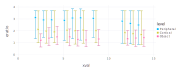

┌ Warning: The following aesthetics are mapped, but not used by any geometry:
│ group
└ @ Gadfly /Users/davidlittle/.julia/packages/Gadfly/ew1SM/src/Gadfly.jl:484
┌ Warning: The following aesthetics are mapped, but not used by any geometry:
│ group
└ @ Gadfly /Users/davidlittle/.julia/packages/Gadfly/ew1SM/src/Gadfly.jl:484


In [53]:
p = plot(dfsumplot,x=:xval,y=:eratio,ymin=:elower,ymax=:eupper,group=:varvalue,color=:level,Geom.point,Geom.errorbar)
draw(SVG(7inch,3inch),p)
draw(PDF(joinpath(plotdir,"fig6.pdf"),7inch,3inch),p)

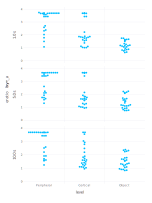

In [30]:
draw(SVG(6inch,8inch),plot(dfplot[dfplot.τ_a .!= 3.0s,:],x=:level,y=:eratio,ygroup=:τ_a,
        Geom.subplot_grid(Geom.beeswarm)))

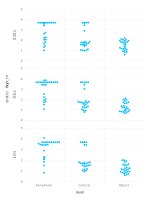

In [31]:
draw(SVG(6inch,8inch),plot(dfplot[dfplot.τ_m .!= 350ms,:],x=:level,y=:eratio,ygroup=:τ_m,Geom.subplot_grid(Geom.beeswarm)))

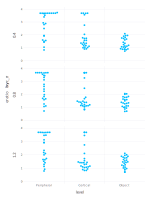

In [32]:
draw(SVG(6inch,8inch),plot(dfplot[dfplot.c_σ .!= 0.2,:],x=:level,y=:eratio,ygroup=:c_σ,Geom.subplot_grid(Geom.beeswarm)))